# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,PowerTransformer
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from scipy.stats import spearmanr
import tensorflow as tf
import statsmodels.stats.api as sms
import statsmodels.regression.linear_model as smf
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn import datasets
from sklearn.metrics import silhouette_score
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','리그','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
defender_df = fm_data_df[fm_data_df['포지션']=='수비수']
defender_df = defender_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [3]:
num_col = [defender_df.columns[i] for i,x in enumerate(defender_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [4]:
defender_df.isna().sum()

이름              0
포지션             0
리그              0
골               0
도움              0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
승               0
무               0
패               0
시즌              0
구단              0
dtype: int64

## 변수 별 분포 확인

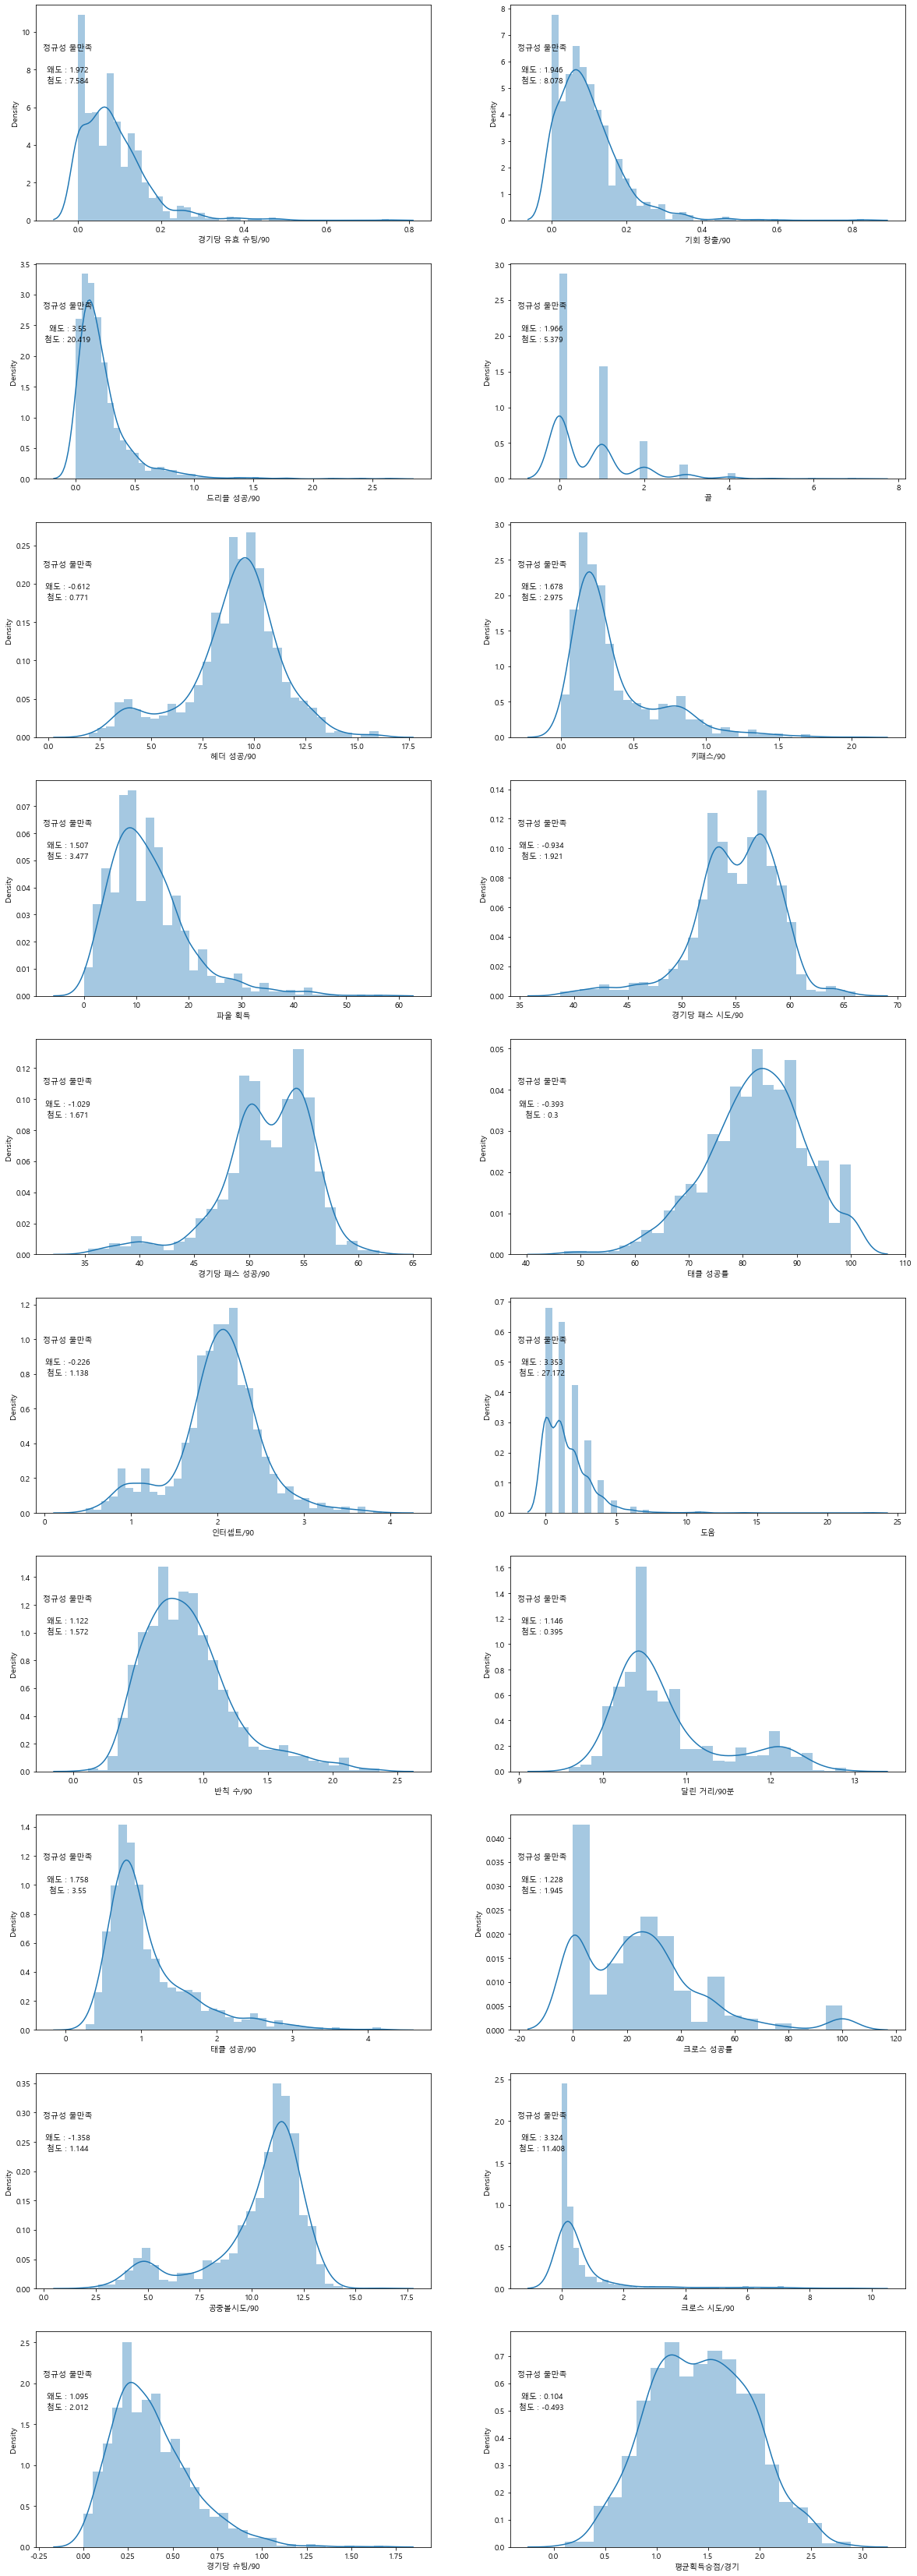

In [5]:
figs , axes = plt.subplots(10,2,figsize=(20,60))

for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    data = defender_df.loc[:,feature]
    sns.distplot(data,ax=ax)
    if stats.shapiro(data)[1]>= 0.05: 
        ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    skew = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    

last_ax = axes.ravel()[-1]
depen_data = defender_df.loc[:,dependent_value]
sns.distplot(depen_data,ax=last_ax)

if stats.shapiro(depen_data)[1]>= 0.05: 
    last_ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
else:
    last_ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
    
skew = stats.skew(depen_data)
kurtosis = stats.kurtosis(depen_data)
last_ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
last_ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)

plt.show()
plt.close()

## 선형성 검정

모든 변수 선형성 만족

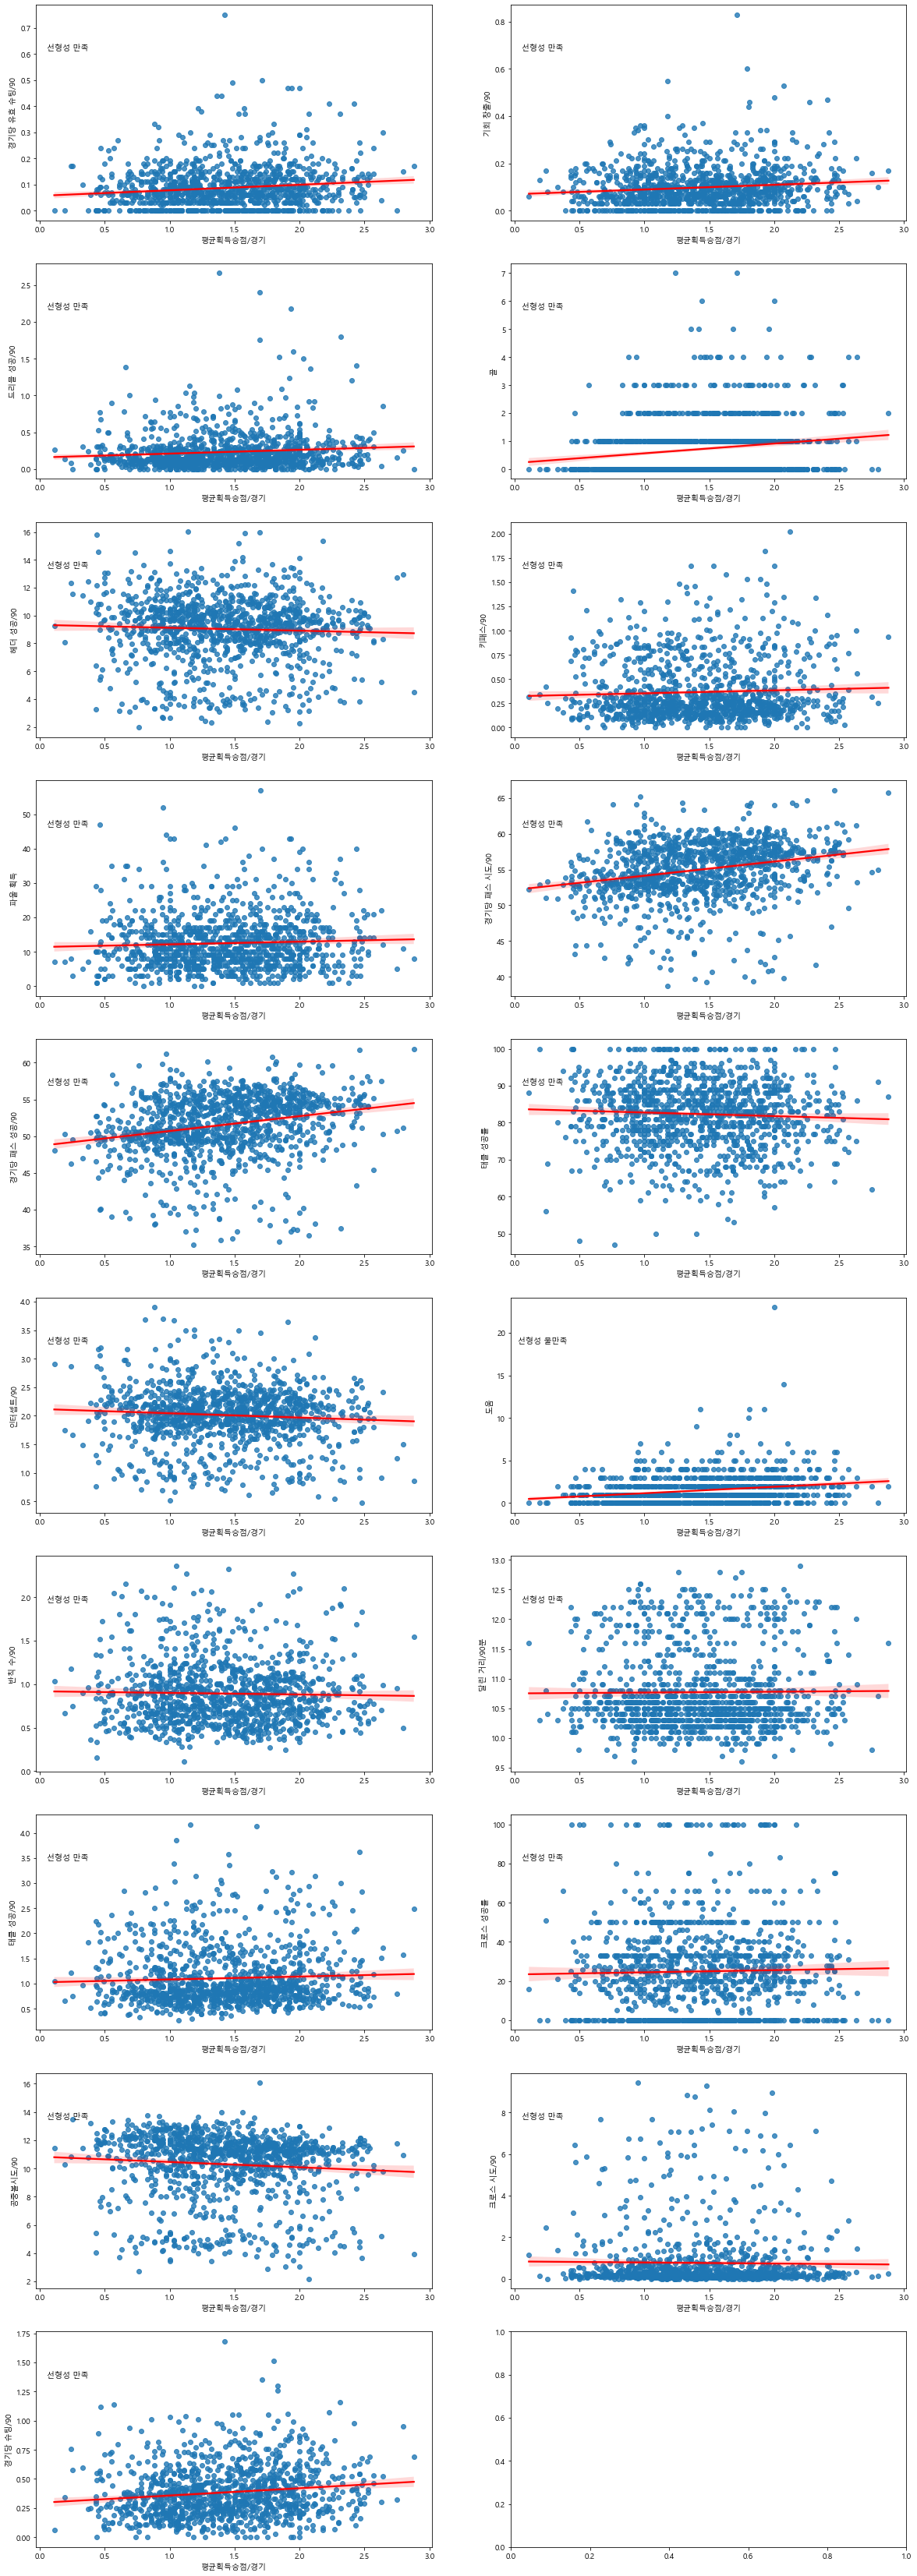

In [6]:
figs , axes = plt.subplots(10,2,figsize=(20,60))


# 독립변수 시각화
for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    sns.regplot(x=dependent_value,y=feature,data=defender_df,line_kws={'color': 'red'},ax=ax)
    model = smf.OLS(defender_df[dependent_value],defender_df[feature]).fit()
    lin_p = sms.linear_rainbow(model,frac=0.5)[1]
    if lin_p>= 0.1: 
        ax.text(x=0.08,y=0.8,s='선형성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='선형성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

## 이상치 탐지

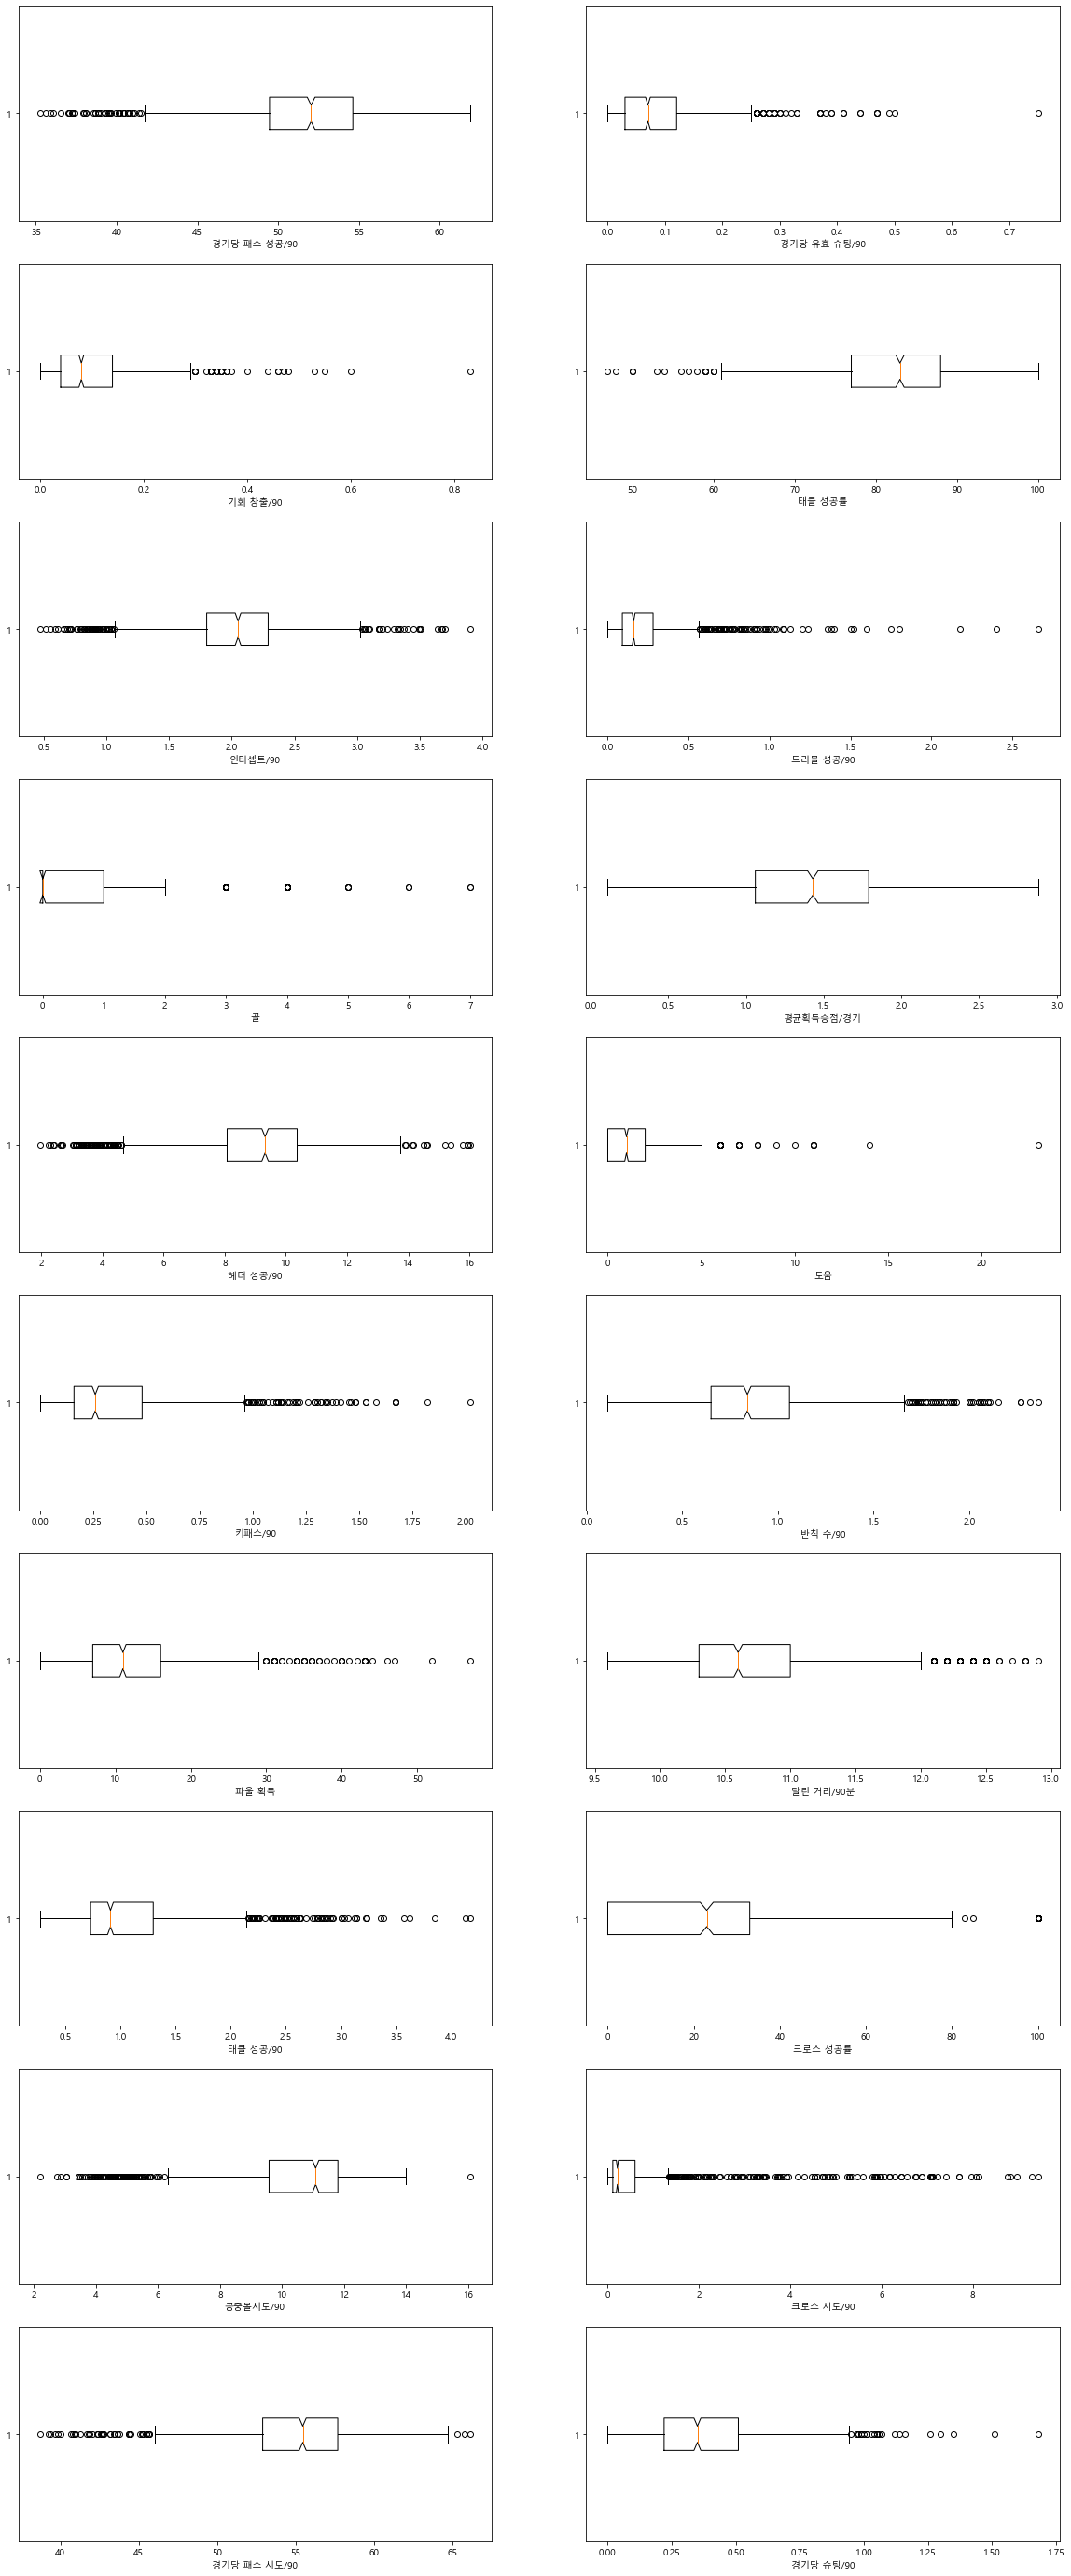

In [7]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),independent_value | set([dependent_value]))) :
    ax.set_xlabel(feature)
    ax.boxplot(defender_df.loc[:,feature],notch=1,vert=0)
    
plt.show()

In [8]:
# 제거해야될 인덱스 셋
total = set([])

for feature in independent_value:
    
    data = defender_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    count = 0
    
    for i,v in enumerate(data):
        if v < low_bound or v > high_bound:
            count += 1
            total.add(i)
            
    print(f'{feature}중 이상치는 {count}개 비율은 약 {np.round(count/len(defender_df)*100,3)}% 입니다',end='\n\n')
    
print(f'이상치가 있는 row의 갯수는 총 {len(defender_df)}개의 데이터 중 {len(total)} 개 입니다.')

경기당 유효 슈팅/90중 이상치는 63개 비율은 약 5.517% 입니다

기회 창출/90중 이상치는 64개 비율은 약 5.604% 입니다

드리블 성공/90중 이상치는 111개 비율은 약 9.72% 입니다

골중 이상치는 68개 비율은 약 5.954% 입니다

헤더 성공/90중 이상치는 115개 비율은 약 10.07% 입니다

키패스/90중 이상치는 166개 비율은 약 14.536% 입니다

파울 획득중 이상치는 61개 비율은 약 5.342% 입니다

경기당 패스 시도/90중 이상치는 51개 비율은 약 4.466% 입니다

경기당 패스 성공/90중 이상치는 52개 비율은 약 4.553% 입니다

태클 성공률중 이상치는 20개 비율은 약 1.751% 입니다

인터셉트/90중 이상치는 129개 비율은 약 11.296% 입니다

도움중 이상치는 25개 비율은 약 2.189% 입니다

반칙 수/90중 이상치는 70개 비율은 약 6.13% 입니다

달린 거리/90분중 이상치는 187개 비율은 약 16.375% 입니다

태클 성공/90중 이상치는 119개 비율은 약 10.42% 입니다

크로스 성공률중 이상치는 39개 비율은 약 3.415% 입니다

공중볼시도/90중 이상치는 122개 비율은 약 10.683% 입니다

크로스 시도/90중 이상치는 192개 비율은 약 16.813% 입니다

경기당 슈팅/90중 이상치는 47개 비율은 약 4.116% 입니다

이상치가 있는 row의 갯수는 총 1142개의 데이터 중 472 개 입니다.


이상치를 제거한다면 데이터 손실이 너무 크다.

##  변수간 상관계수 분석 및 다중공선성 확인 - 독립성 검정

### 상관계수

#### 상관계수 시각화

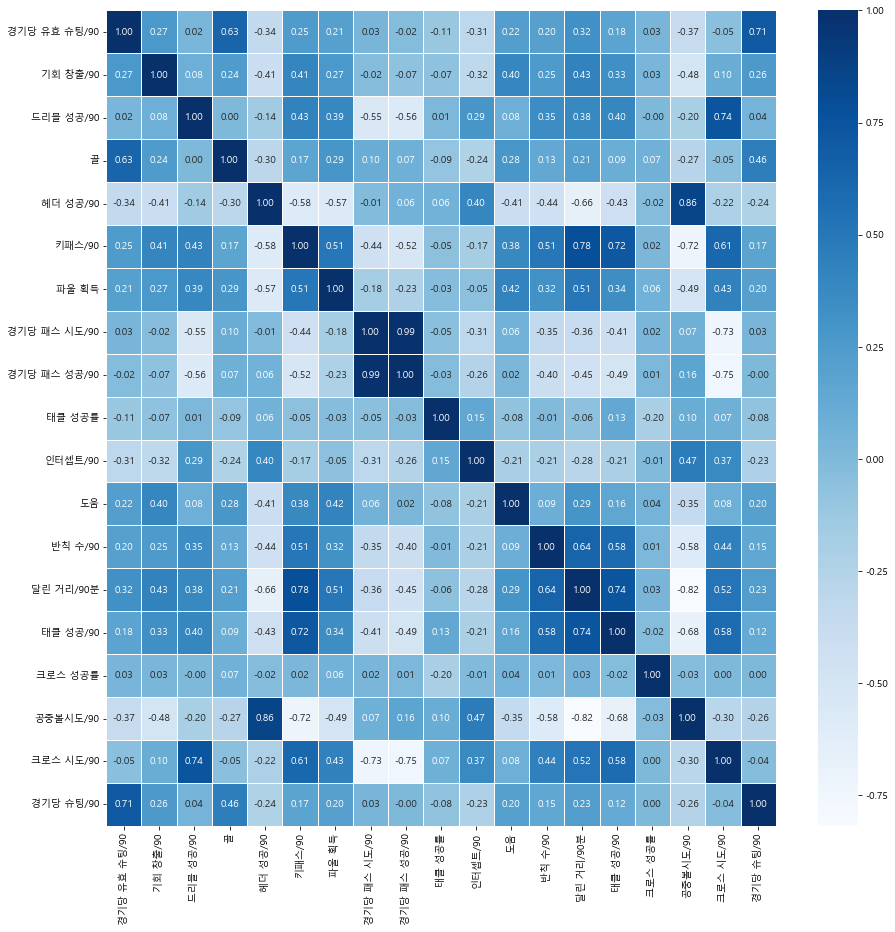

In [9]:
plt.figure(figsize=(15,15))
sns.heatmap(data = defender_df.loc[:,independent_value].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues');

#### 독립변수 간 상관계수가 0.9이상인 변수들

In [10]:
# 상관계수의 절대값이 0.7 이상인것들
high_corr_list = []
feature_comb = list(combinations(independent_value,2))
corr_dict_pair = {}

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for a,b in feature_comb:
    spearmann = spearmanr(defender_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
    if spearmann[0] >= 0.9 or spearmann[0] <= -0.9:
        high_corr_list.append([a,b,spearmann[0]])

pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

,변수 1,변수 2,상관계수
0,경기당 패스 시도/90,경기당 패스 성공/90,0.982579


#### 상관계수와 다중공선성

In [11]:
corr_dict_dependent = {}
corr_list_dependent = []

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for val in independent_value:
    spearmann = spearmanr(defender_df[[val,dependent_value]])
    corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    corr_list_dependent.append([val,dependent_value,spearmann[0]])

pd.DataFrame(sorted(corr_list_dependent,key=lambda x : np.abs(x[2]),reverse=True),columns=['종속변수','독립변수','상관계수']).head(20)

,종속변수,독립변수,상관계수
0,경기당 패스 시도/90,평균획득승점/경기,0.284672
1,경기당 패스 성공/90,평균획득승점/경기,0.276354
2,도움,평균획득승점/경기,0.227565
3,골,평균획득승점/경기,0.166221
4,경기당 슈팅/90,평균획득승점/경기,0.149578
5,공중볼시도/90,평균획득승점/경기,-0.130493
6,경기당 유효 슈팅/90,평균획득승점/경기,0.120730
7,기회 창출/90,평균획득승점/경기,0.108428
8,드리블 성공/90,평균획득승점/경기,0.107246
9,헤더 성공/90,평균획득승점/경기,-0.061551


In [12]:
this_vif = pd.DataFrame()
this_vif["VIF 계수"] = [vif(defender_df.loc[:,independent_value].values,i) for i in range(defender_df.loc[:,independent_value].values.shape[1])]
this_vif["종속변수"] = defender_df.loc[:,independent_value].columns
this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
this_vif

,VIF 계수,종속변수
0,2.318007,크로스 성공률
1,2.723918,골
2,2.729461,도움
3,3.434880,기회 창출/90
4,4.328384,드리블 성공/90
5,6.353960,경기당 유효 슈팅/90
6,7.301852,파울 획득
7,7.743273,크로스 시도/90
8,8.002789,경기당 슈팅/90
9,10.356788,키패스/90


## EDA Summary


- 모든 독립변수는 선형성을 만족한다.
- 이상치가 있는 row를 모두 삭제한다면 data loss가 너무 크므로 이상치에 강건한 스케일링을 활용해야 한다.
- 상관계수가 높은 독립변수간 상관관계제거, 다중공선성 해결 필요

# 데이터 전처리

## 전처리 중간중간 쓰일 함수

In [13]:
def check_vif(independent_value):
    this_vif = pd.DataFrame()
    this_vif["VIF 계수"] = [vif(defender_df.loc[:,independent_value].values,i) for i in range(defender_df.loc[:,independent_value].values.shape[1])]
    this_vif["종속변수"] = defender_df.loc[:,independent_value].columns
    this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
    return this_vif

In [14]:
def check_indepen_high_corr(independent_value):
    # 상관계수의 절대값이 0.7 이상인것들
    high_corr_list = []
    feature_comb = list(combinations(independent_value,2))
    corr_dict_pair = {}

    # 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for a,b in feature_comb:
        spearmann = spearmanr(defender_df[[a,b]])
        corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
        if spearmann[0] >= 0.9 or spearmann[0] <= -0.9:
            high_corr_list.append([a,b,spearmann[0]])

    return pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

In [15]:
def check_dependent_corr(independent_value):
    corr_dict_dependent = {}
    corr_list_dependent = []

    # 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for val in independent_value:
        spearmann = spearmanr(defender_df[[val,dependent_value]])
        corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
        corr_list_dependent.append([val,dependent_value,spearmann[0]])

    df = pd.DataFrame(sorted(corr_list_dependent,key=lambda x : np.abs(x[2]),reverse=True),columns=['종속변수','독립변수','상관계수'])
    return df

## 결측치 처리

결측치가 없음

## 다중공선성, 상관계수 처리 (기준: VIF >= 10 , 상관계수 > =+- 0.7) 및 처리

1. 골,경기당 슈팅, 유효 슈팅
2. 도움, 패스시도,패스성공,키패스
3. 태클 성공률, 태클 성공/90
4. 공중볼 시도, 헤더성공
5. 드리블 시도
6. 인터셉트/90
7. 크로스시도 크로스 성공
8. 파울 획득
9. 반칙 수 /90
10. 달린거리/90분

### 경기당 패스 성공/90 경기당 패스 시도/90

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [16]:
defender_df[['경기당 패스 성공/90','경기당 패스 시도/90','평균획득승점/경기']].corr()

,경기당 패스 성공/90,경기당 패스 시도/90,평균획득승점/경기
경기당 패스 성공/90,1.000000,0.985731,0.233133
경기당 패스 시도/90,0.985731,1.000000,0.240698
평균획득승점/경기,0.233133,0.240698,1.000000


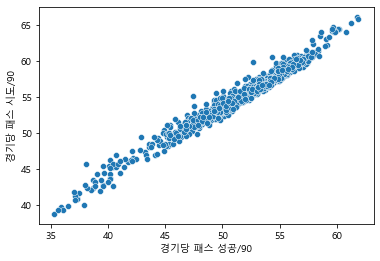

In [17]:
sns.scatterplot(x='경기당 패스 성공/90',y='경기당 패스 시도/90',data=defender_df);

#### 피쳐 엔지니어링

In [18]:
# PSTL = Pass sucess try linear

defender_df['PSTL'] = (defender_df['경기당 패스 성공/90']) + (defender_df['경기당 패스 시도/90']*1.2)

independent_value.add('PSTL')
independent_value = independent_value - set(['경기당 패스 성공/90','경기당 패스 시도/90'])

defender_df[['이름','PSTL']].sort_values(by='PSTL',ascending=False).head()

,이름,PSTL
619,Rodri,141.090
977,João Palhinha,140.778
52,Ellyes Skhiri,139.520
295,William Carvalho,137.556
108,Fernando,137.378


#### 상관계수 확인 (통과)

In [19]:
defender_df[['PSTL','평균획득승점/경기']].corr()

,PSTL,평균획득승점/경기
PSTL,1.000000,0.238012
평균획득승점/경기,0.238012,1.000000


### 피쳐 삭제

In [20]:
independent_value

{'PSTL',
 '경기당 슈팅/90',
 '경기당 유효 슈팅/90',
 '골',
 '공중볼시도/90',
 '기회 창출/90',
 '달린 거리/90분',
 '도움',
 '드리블 성공/90',
 '반칙 수/90',
 '인터셉트/90',
 '크로스 성공률',
 '크로스 시도/90',
 '키패스/90',
 '태클 성공/90',
 '태클 성공률',
 '파울 획득',
 '헤더 성공/90'}

In [21]:
independent_value = independent_value - set(['달린 거리/90분','반칙 수/90','크로스 시도/90','크로스 성공률','키패스/90','파울 획득','인터셉트/90','공중볼시도/90','기회 창출/90','골','도움','경기당 슈팅/90','경기당 유효 슈팅/90','드리블 성공/90','태클 성공률'])

In [22]:
check_dependent_corr(independent_value)

,종속변수,독립변수,상관계수
0,PSTL,평균획득승점/경기,0.281853
1,헤더 성공/90,평균획득승점/경기,-0.061551
2,태클 성공/90,평균획득승점/경기,0.056789


In [23]:
check_vif(independent_value)

,VIF 계수,종속변수
0,4.245249,태클 성공/90
1,16.103821,헤더 성공/90
2,22.373747,PSTL


In [24]:
independent_value

{'PSTL', '태클 성공/90', '헤더 성공/90'}

In [25]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수


### 최종 종속변수

In [26]:
independent_value

{'PSTL', '태클 성공/90', '헤더 성공/90'}

In [27]:
defender_df.columns

Index(['이름', '포지션', '리그', '골', '도움', '경기당 팀 득점/90', '경기당 팀 실점/90', '크로스 성공률',
       '파울 획득', '반칙 수/90', '기회 창출/90', '경기당 유효 슈팅/90', '경기당 슈팅/90', '인터셉트/90',
       '달린 거리/90분', '공중볼시도/90', '태클 성공률', '경기당 패스 시도/90', '경기당 패스 성공/90',
       '키패스/90', '태클 성공/90', '드리블 성공/90', '헤더 성공/90', '크로스 시도/90', '평균획득승점/경기',
       '승', '무', '패', '시즌', '구단', 'PSTL'],
      dtype='object')

## 이상치 처리

이상치를 제외하면 데이터 손실이 너무 크기 때문에 Quantile transform을 사용해서 이상치를 고려한 normalization을 진행하기로 함.

## 데이터 정규화

In [28]:
x_train,x_test,y_train,y_test = train_test_split(defender_df.loc[:,independent_value],defender_df.loc[:,dependent_value])

defender_x_qt = RobustScaler().fit(x_train.loc[:,independent_value])

x_train.loc[:,independent_value] = defender_x_qt.transform(x_train.loc[:,independent_value])
x_test.loc[:,independent_value] = defender_x_qt.transform(x_test.loc[:,independent_value])

# 모델 생성

In [29]:
inputs_layer = Input(shape=(len(independent_value),))
hidden1 = Dense(10,activation='relu')(inputs_layer)
hidden2 = Dense(256,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden1)
hidden3 = Dense(256,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden2)
hidden3 = Dense(10,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden2)
output = Dense(1,activation='linear')(hidden3)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.001))
     
model.fit(x_train.loc[:,independent_value],y_train,batch_size=100,epochs=700,validation_data=(x_test.loc[:,independent_value],y_test))  
predict_result=model.predict(x_test.loc[:,independent_value])
mae = mean_absolute_error(y_test,predict_result)

Epoch 1/700
9/9 [==============================] - 0s 14ms/step - loss: 2.4444 - val_loss: 1.8719
Epoch 2/700
9/9 [==============================] - 0s 2ms/step - loss: 1.7290 - val_loss: 1.3016
Epoch 3/700
9/9 [==============================] - 0s 2ms/step - loss: 1.2018 - val_loss: 1.0800
Epoch 4/700
9/9 [==============================] - 0s 2ms/step - loss: 0.9453 - val_loss: 0.8426
Epoch 5/700
9/9 [==============================] - 0s 2ms/step - loss: 0.7434 - val_loss: 0.6384
Epoch 6/700
9/9 [==============================] - 0s 2ms/step - loss: 0.6321 - val_loss: 0.5541
Epoch 7/700
9/9 [==============================] - 0s 2ms/step - loss: 0.5816 - val_loss: 0.5106
Epoch 8/700
9/9 [==============================] - 0s 2ms/step - loss: 0.5361 - val_loss: 0.4862
Epoch 9/700
9/9 [==============================] - 0s 2ms/step - loss: 0.5005 - val_loss: 0.4594
Epoch 10/700
9/9 [==============================] - 0s 2ms/step - loss: 0.4689 - val_loss: 0.4349
Epoch 11/700
9/9 [==========

9/9 [==============================] - 0s 2ms/step - loss: 0.2286 - val_loss: 0.2241
Epoch 85/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2291 - val_loss: 0.2244
Epoch 86/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2281 - val_loss: 0.2234
Epoch 87/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2273 - val_loss: 0.2247
Epoch 88/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2278 - val_loss: 0.2227
Epoch 89/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2268 - val_loss: 0.2259
Epoch 90/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2267 - val_loss: 0.2233
Epoch 91/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2265 - val_loss: 0.2224
Epoch 92/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2263 - val_loss: 0.2220
Epoch 93/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2260 - val_loss: 0.2234
Epoch 94/700
9/9 [===============

9/9 [==============================] - 0s 2ms/step - loss: 0.2173 - val_loss: 0.2127
Epoch 168/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2175 - val_loss: 0.2117
Epoch 169/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2170 - val_loss: 0.2129
Epoch 170/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2182 - val_loss: 0.2125
Epoch 171/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2194 - val_loss: 0.2153
Epoch 172/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2193 - val_loss: 0.2115
Epoch 173/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2167 - val_loss: 0.2120
Epoch 174/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2171 - val_loss: 0.2140
Epoch 175/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2173 - val_loss: 0.2138
Epoch 176/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2165 - val_loss: 0.2127
Epoch 177/700
9/9 [=====

Epoch 250/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2144 - val_loss: 0.2120
Epoch 251/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2148 - val_loss: 0.2068
Epoch 252/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2148 - val_loss: 0.2092
Epoch 253/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2141 - val_loss: 0.2113
Epoch 254/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2145 - val_loss: 0.2081
Epoch 255/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2136 - val_loss: 0.2099
Epoch 256/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2133 - val_loss: 0.2092
Epoch 257/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2135 - val_loss: 0.2104
Epoch 258/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2134 - val_loss: 0.2085
Epoch 259/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2143 - val_loss: 0.2118
Epoch 260/

9/9 [==============================] - 0s 2ms/step - loss: 0.2128 - val_loss: 0.2082
Epoch 333/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2122 - val_loss: 0.2080
Epoch 334/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2127 - val_loss: 0.2068
Epoch 335/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2121 - val_loss: 0.2063
Epoch 336/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2116 - val_loss: 0.2072
Epoch 337/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2115 - val_loss: 0.2067
Epoch 338/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2118 - val_loss: 0.2061
Epoch 339/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2114 - val_loss: 0.2091
Epoch 340/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2126 - val_loss: 0.2083
Epoch 341/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2124 - val_loss: 0.2098
Epoch 342/700
9/9 [=====

Epoch 415/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2107 - val_loss: 0.2066
Epoch 416/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2112 - val_loss: 0.2040
Epoch 417/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2110 - val_loss: 0.2055
Epoch 418/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2103 - val_loss: 0.2039
Epoch 419/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2121 - val_loss: 0.2054
Epoch 420/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2103 - val_loss: 0.2032
Epoch 421/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2107 - val_loss: 0.2060
Epoch 422/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2104 - val_loss: 0.2051
Epoch 423/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2103 - val_loss: 0.2064
Epoch 424/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.2032
Epoch 425/

9/9 [==============================] - 0s 2ms/step - loss: 0.2089 - val_loss: 0.2059
Epoch 498/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2093 - val_loss: 0.2030
Epoch 499/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2098 - val_loss: 0.2057
Epoch 500/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2094 - val_loss: 0.2044
Epoch 501/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2089 - val_loss: 0.2018
Epoch 502/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2093 - val_loss: 0.2083
Epoch 503/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2094 - val_loss: 0.2025
Epoch 504/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2091 - val_loss: 0.2101
Epoch 505/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2110 - val_loss: 0.2032
Epoch 506/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2098 - val_loss: 0.2058
Epoch 507/700
9/9 [=====

Epoch 580/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2086 - val_loss: 0.2031
Epoch 581/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2085 - val_loss: 0.2033
Epoch 582/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2092 - val_loss: 0.2043
Epoch 583/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2088 - val_loss: 0.2032
Epoch 584/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2085 - val_loss: 0.2074
Epoch 585/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2090 - val_loss: 0.2021
Epoch 586/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2089 - val_loss: 0.2066
Epoch 587/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2076 - val_loss: 0.2025
Epoch 588/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2076 - val_loss: 0.2063
Epoch 589/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2086 - val_loss: 0.2053
Epoch 590/

9/9 [==============================] - 0s 2ms/step - loss: 0.2078 - val_loss: 0.2059
Epoch 663/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2072 - val_loss: 0.2036
Epoch 664/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2067 - val_loss: 0.2072
Epoch 665/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2093 - val_loss: 0.2033
Epoch 666/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2083 - val_loss: 0.2043
Epoch 667/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2115 - val_loss: 0.2039
Epoch 668/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2087 - val_loss: 0.2055
Epoch 669/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2073 - val_loss: 0.2036
Epoch 670/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2074 - val_loss: 0.2049
Epoch 671/700
9/9 [==============================] - 0s 2ms/step - loss: 0.2074 - val_loss: 0.2054
Epoch 672/700
9/9 [=====

In [30]:
mae

0.36388962917394574

In [31]:
independent_value

{'PSTL', '태클 성공/90', '헤더 성공/90'}

In [32]:
defender_df.loc[:,independent_value] = defender_x_qt.transform(defender_df.loc[:,independent_value])

In [33]:
y_pred = model.predict(defender_df.loc[:,independent_value])

In [34]:
defender_df['예측_PPG'] = y_pred

In [35]:
defender_df.sort_values(by='예측_PPG',ascending=False).head(5)

,이름,포지션,리그,골,도움,경기당 팀 득점/90,경기당 팀 실점/90,크로스 성공률,파울 획득,반칙 수/90,...,헤더 성공/90,크로스 시도/90,평균획득승점/경기,승,무,패,시즌,구단,PSTL,예측_PPG
619,Rodri,수비수,잉글랜드 프리미어 리그,0,1,1.63,0.49,25.0,14,0.60,...,-0.167401,0.22,2.46,32.0,5.0,4.0,2022-2023,맨시티,2.027785,2.165933
624,Fernandinho,수비수,잉글랜드 프리미어 리그,1,1,2.57,0.61,0.0,11,1.83,...,-1.718062,0.27,2.48,24.0,5.0,2.0,2022-2023,맨시티,1.114626,2.000845
625,Julian Weigl,수비수,잉글랜드 프리미어 리그,0,6,1.88,0.72,0.0,9,1.53,...,-1.951542,0.00,2.25,25.0,6.0,5.0,2022-2023,맨 레드,1.671985,1.940110
847,Ali Al Musrati,수비수,스페인 프리메라 디비전,1,2,1.02,1.11,0.0,4,0.92,...,-0.026432,0.18,2.27,20.0,8.0,2.0,2023-2024,레알 마드리드,0.731499,1.937205
1107,Hidemasa Morita,수비수,이탈리아 세리에 A,1,2,1.55,1.10,66.0,11,0.82,...,-2.704846,0.27,2.07,17.0,5.0,5.0,2023-2024,아탈란타,0.821366,1.919919


# 모델검정

In [36]:
residual = defender_df['평균획득승점/경기'] - defender_df['예측_PPG']

## 잔차의 정규성 검정

In [37]:
# 정규성 불만족
stats.shapiro(residual)

ShapiroResult(statistic=0.9961969256401062, pvalue=0.006580178625881672)

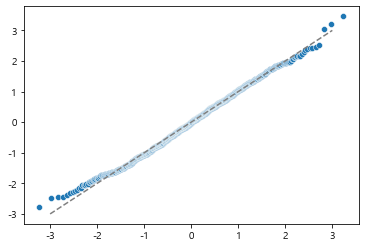

In [38]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey');

## 잔차의 등분산성 검정

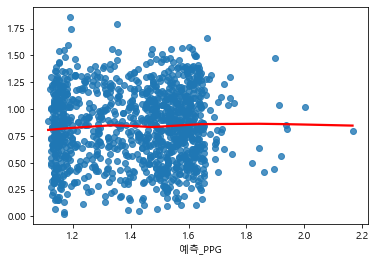

In [39]:
sns.regplot(defender_df['예측_PPG'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'});

In [40]:
# 등분산성 불만족
stats.levene(defender_df['평균획득승점/경기'],defender_df['예측_PPG'])

LeveneResult(statistic=784.6585846268434, pvalue=1.1777894908315092e-148)

In [41]:
from statsmodels.stats.stattools import durbin_watson

# 독립성 불만족
durbin_watson(residual)

0.8417865135818324

In [42]:
mean_absolute_error(defender_df['평균획득승점/경기'],defender_df['예측_PPG'])

0.3650334543897892

In [43]:
np.sqrt(mean_squared_error(defender_df['평균획득승점/경기'],defender_df['예측_PPG']))

0.44760752762518347

In [44]:
with open('./models/defender/defender_qt.pickle','wb') as f:
     pickle.dump(defender_x_qt,f)

In [45]:
model.save('./models/defender/defender_nn.h5')